<a href="https://colab.research.google.com/github/nhatminh-it/fruits_classification/blob/master/Extract_color_fruit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Import thư viện cần thiết**

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import pandas as pd

**Clustering ảnh**

Function INPUT: ảnh 200x200

Function OUTPUT: ảnh chỉ có 2 màu sau khi được cluster

In [ ]:
def clustering_image(img):
  vectorized = img.reshape((-1,3))
  vectorized = np.float32(vectorized)
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  attempts=10
  ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
  center = np.uint8(center)
  res = center[label.flatten()]
  result_image = res.reshape((img.shape))
  return result_image, center

**Loại bỏ màu sáng**

Function INPUT: ảnh có 2 màu được cluster, 2 màu của ảnh đó

Function OUTPUT: ảnh chỉ còn 1 màu (màu tối hơn)

In [ ]:
def remove_light_color(img, center_color):
  light_color = max(sum(center_color[0]), sum(center_color[1]))
  for x in range(img.shape[0]):
    for y in range(img.shape[1]):
      if sum(img[x][y]) == light_color:
        img[x][y][0]=0
        img[x][y][1]=0
        img[x][y][2]=0
  return img

**Xem các bước xử lý ảnh từng loại trái**

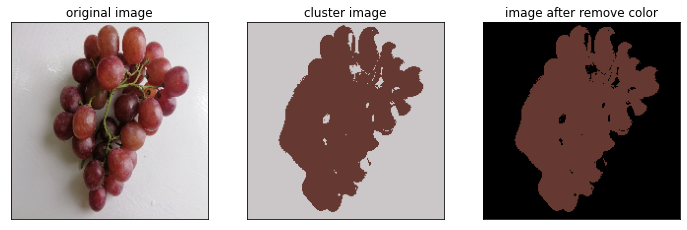

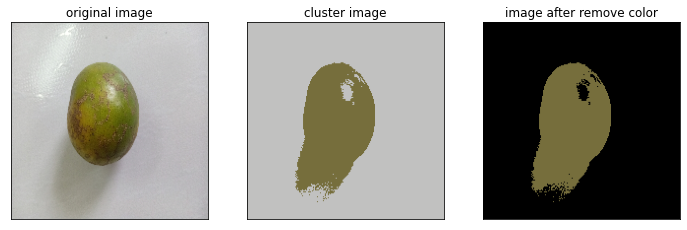

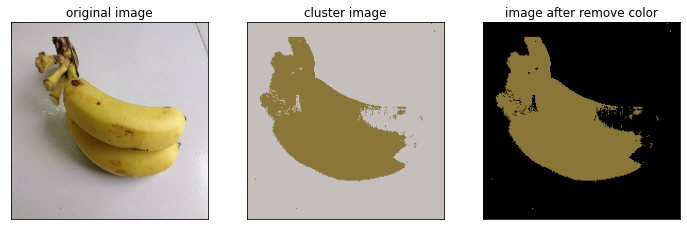

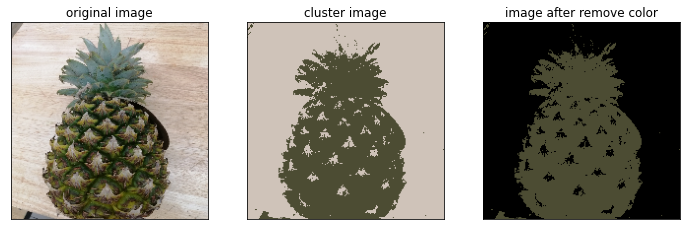

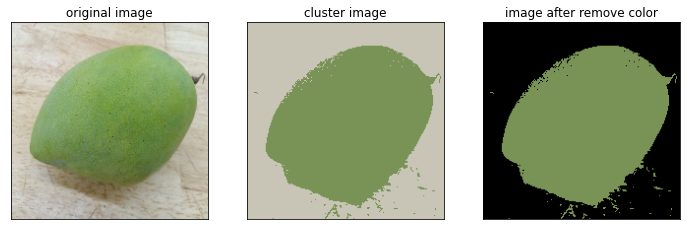

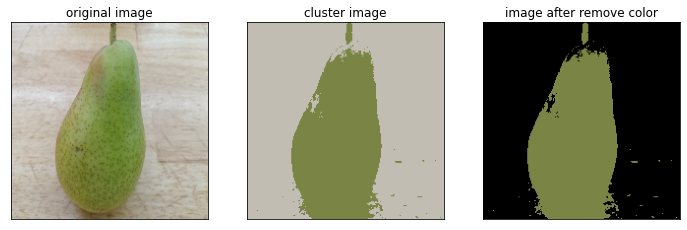

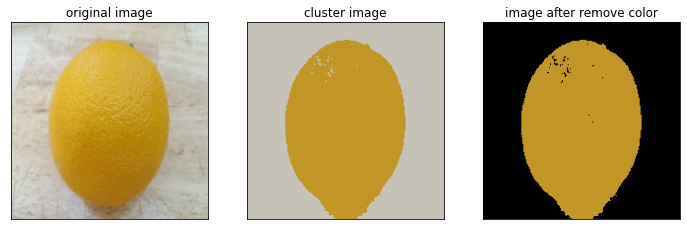

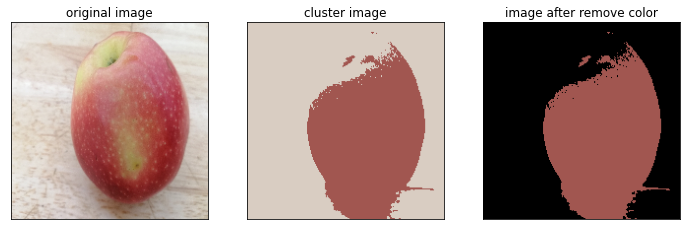

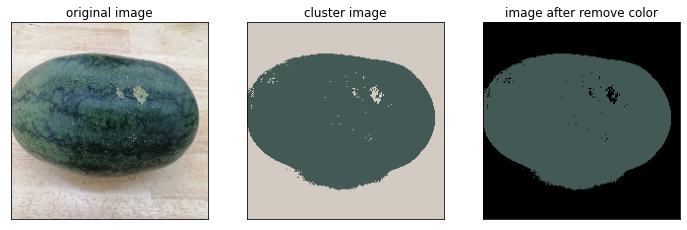

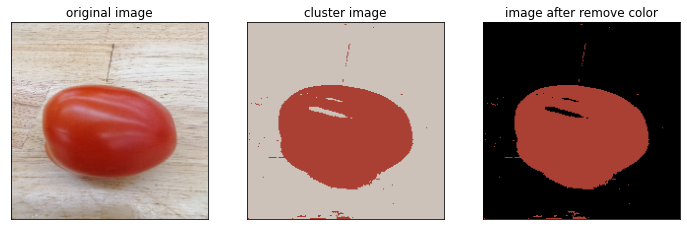

In [ ]:
simple_path = '/content/drive/My Drive/Fruit recognition/simple_image'
for name in os.listdir(simple_path):
  img = cv2.imread(simple_path+'/'+name)
  resized = cv2.resize(img, (200, 200))
  resized = cv2.cvtColor(resized,cv2.COLOR_BGR2RGB)

  cluster_img, center_color= clustering_image(resized)

  figure_size = 12
  plt.figure(figsize=(figure_size,figure_size))

  plt.subplot(1,3,1),plt.imshow(resized)
  plt.title('original image'), plt.xticks([]), plt.yticks([])

  plt.subplot(1,3,2),plt.imshow(cluster_img)
  plt.title('cluster image'), plt.xticks([]), plt.yticks([])

  final_img = remove_light_color(cluster_img, center_color)

  plt.subplot(1,3,3),plt.imshow(final_img)
  plt.title('image after remove color'), plt.xticks([]), plt.yticks([])
 
  plt.show()

**Đọc, xử lý, và chia data thành 2 tập train và test**

done 250 image


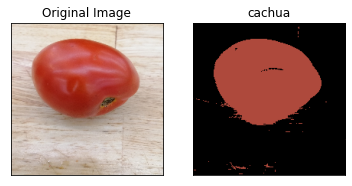

done 500 image


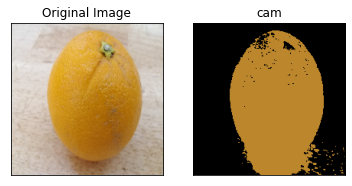

done 750 image


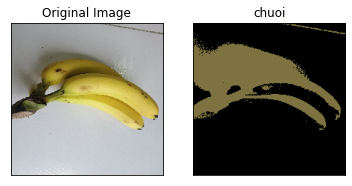

done 1000 image


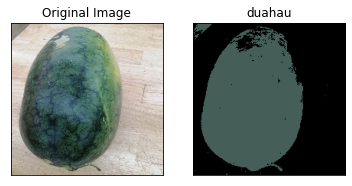

done 1250 image


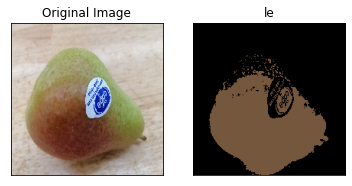

done 1500 image


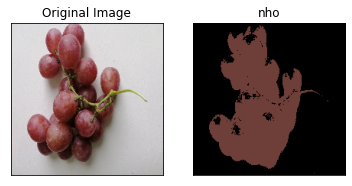

done 1750 image


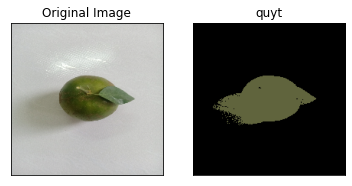

done 2000 image


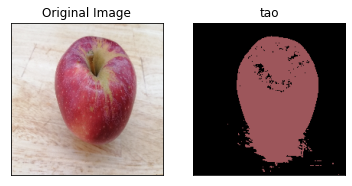

done 2250 image


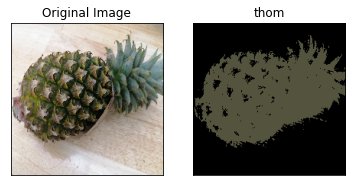

done 2500 image


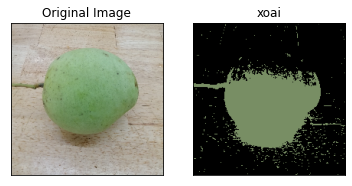

In [ ]:
#@title read and pre-processing image
path = '/content/drive/My Drive/Fruit recognition/data'#@param {type:"string"}
name_fruits = ['cachua', 'cam', 'chuoi', 'duahau', 'le', 'nho', 'quyt', 'tao', 'thom', 'xoai']
dataset_train = {}
dataset_test = {}
test_size = 0.20 #@param {type:"number"}
number = 1
dim = (200, 200)
for name in name_fruits:
  index = 0
  images_train = []
  images_test = []
  while index < 250:
    img_path = path+'/'+name+'/'+name+'_'+str(index)+'.jpg'
    index+=1
    #print(img_path)
    fruit_img = cv2.imread(img_path)
    fruit_img = cv2.resize(fruit_img, dim)
    fruit_img = cv2.cvtColor(fruit_img,cv2.COLOR_BGR2RGB)

    cluster_img, center_color= clustering_image(fruit_img)

    cluster_img = remove_light_color(cluster_img, center_color)
    
    if len(images_test) < test_size*(len(os.listdir(path+'/'+name))):
      images_test.append(cluster_img)
    else:
      images_train.append(cluster_img)
   
    if number%250==0:
      print('done {} image'.format(number))
      figure_size = 6
      plt.figure(figsize=(figure_size,figure_size))

      plt.subplot(1,2,1),plt.imshow(fruit_img)
      plt.title('Original Image'), plt.xticks([]), plt.yticks([])

      plt.subplot(1,2,2),plt.imshow(cluster_img)
      plt.title(name), plt.xticks([]), plt.yticks([])

     
      plt.show()

    number+=1
  dataset_train[name] = images_train
  dataset_test[name] = images_test

# 1. Extract each 40x40 pixels section

**Chia nhỏ bức ảnh thành từng phần 40x40 pixel sau đó tính trung bình độ lệch chuẩn của từng phần**

Defining hàm để chia nhỏ bức ảnh 200x200 pixels thành từng phần nhỏ 40x40 pixels, và tính trung bình, độ lệch chuẩn của từng phần.

Function INPUT: 1 cảnh kích cỡ 200x200

Function OUTPUT: mảng feature bao gồm trung bình cộng và độ lệch chuẩn của 25 phần (40x40 pixel)

In [ ]:
def features_grid(img):
    features = np.array([], dtype='uint8')
    section = 1
    
    for y in range(0, img.shape[0], 40):
        for x in range(0, img.shape[1], 40):

            # Cropping the image into a section.
            section_img = img[y:y+40, x:x+40]
            
            # Claculating the mean and stdev of the sectioned image.
            section_mean = np.mean(section_img)
            section_std = np.std(section_img)
            
            # Appending the above calculated values into features array.
            features = np.append(features, [section_mean, section_std])
    
    # Returning the features array.
    return features

Khởi tạo tên các cột cho dataframe

In [ ]:
feature_names = []
section = 1
    
for y in range(0, 200, 40):
    for x in range(0, 200, 40):
        feature_names.append(f"sec{section}_mean")
        feature_names.append(f"sec{section}_std")
        section += 1

Hàm tạo 1 dataframe dựa trên bộ dataset sử dụng cách chia nhỏ bức ảnh thành từng phần 40x40

Function INPUT: 1 bộ dataset.

Function OUTPUT: dataframe với cột là feature, hàng là ảnh.

In [ ]:
def create_df_with_many_imgs(dataset):
  all_imgs = np.zeros((1, 50), dtype='uint8')
  name_fruits = []
  #all_imgs = np.append(all_imgs, img_features, axis=0)
  for name in dataset:
    for img in dataset[name]:
      name_fruits.append(name)
      img_features = features_grid(img)
      
      img_features = img_features.reshape(1, img_features.shape[0])

      all_imgs = np.append(all_imgs, img_features, axis=0)

  all_imgs = all_imgs[1:]

  df = pd.DataFrame(all_imgs, columns=feature_names)
  df.insert(loc=0, column="name", value=name_fruits)
  return df

Sử dụng hàm đã tạo trên để khởi tạo 2 dataframe train và test.

In [ ]:
df_train = create_df_with_many_imgs(dataset_train)
df_test = create_df_with_many_imgs(dataset_test)

In [ ]:
df_test.head()

,name,sec1_mean,sec1_std,sec2_mean,sec2_std,sec3_mean,sec3_std,sec4_mean,sec4_std,sec5_mean,sec5_std,sec6_mean,sec6_std,sec7_mean,sec7_std,sec8_mean,sec8_std,sec9_mean,sec9_std,sec10_mean,sec10_std,sec11_mean,sec11_std,sec12_mean,sec12_std,sec13_mean,sec13_std,sec14_mean,sec14_std,sec15_mean,sec15_std,sec16_mean,sec16_std,sec17_mean,sec17_std,sec18_mean,sec18_std,sec19_mean,sec19_std,sec20_mean,sec20_std,sec21_mean,sec21_std,sec22_mean,sec22_std,sec23_mean,sec23_std,sec24_mean,sec24_std,sec25_mean,sec25_std
0,cachua,0.0,0.0,0.0,0.0,1.005833,11.129258,0.059167,2.709597,0.000000,0.000000,0.118333,3.831035,26.802500,51.079348,33.665833,55.191972,10.472500,34.503123,0.0000,0.000000,16.034167,41.635483,90.229167,55.321405,89.164167,55.850643,90.702500,55.077947,9.821667,33.509313,6.390000,27.431239,77.981667,60.000990,94.666667,52.828864,73.544167,61.004987,6.035000,26.698526,0.059167,2.709597,3.845833,21.509571,23.430000,48.577980,2.189167,16.339766,0.000000,0.000000
1,cachua,0.0,0.0,0.0,0.0,0.000000,0.000000,1.615833,13.386869,3.404792,19.275019,0.000000,0.000000,42.357917,54.516662,69.653958,54.644587,39.761042,53.787636,0.0000,0.000000,2.943125,17.958526,90.890625,44.342107,92.275625,43.224786,86.966458,47.144484,0.000000,0.000000,0.000000,0.000000,59.728125,56.154846,92.275625,43.224786,38.780000,53.476832,0.000000,0.000000,0.173125,4.410289,1.846667,14.296264,9.925833,31.911863,0.000000,0.000000,0.000000,0.000000
2,cachua,0.0,0.0,0.0,0.0,0.643958,8.645260,0.000000,0.000000,0.000000,0.000000,5.971250,25.714547,54.443750,58.222928,78.680000,54.699704,49.350625,57.655335,0.7025,9.027402,45.311250,56.877802,93.666667,46.456670,93.608125,46.501111,93.666667,46.456670,19.670000,43.689142,38.520417,54.880100,93.315417,46.721579,93.666667,46.456670,66.678958,57.757222,1.053750,11.039514,0.000000,0.000000,20.606667,44.500921,39.925417,55.367716,3.512500,19.939906,0.058542,2.613210
3,cachua,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.637500,44.933018,106.426042,46.754759,37.127083,57.753478,0.0000,0.000000,0.000000,0.000000,55.690625,63.003025,118.259375,32.088368,66.266667,63.422043,0.000000,0.000000,0.073958,3.063452,16.418750,42.603414,106.056250,47.091725,44.227083,60.492228,0.073958,3.063452,10.058333,34.291373,0.073958,3.063452,2.662500,18.192267,5.029167,24.763716,3.254167,20.064386
4,cachua,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.337917,26.137528,82.333125,51.164902,46.039583,55.989327,0.0000,0.000000,0.000000,0.000000,24.933125,47.158561,95.666667,42.026447,62.601875,56.795155,0.000000,0.000000,0.000000,0.000000,8.789375,30.428092,91.122500,45.786488,24.395000,46.787381,0.000000,0.000000,0.000000,0.000000,0.239167,5.219064,2.571042,16.935760,0.119583,3.692373,0.059792,2.611586


Lưu 2 dataframe trên về drive

In [ ]:
df_train.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_cluster_features_1_train.csv", index=False)
df_test.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_cluster_features_1_test.csv", index=False)

# 2. Extract each channel color

**Thay vì chia nhỏ bức ảnh thành tức phần 40x40 pixel, tính trung bình và độ lệch chuẩn của từng channel màu để làm feature**

Hàm tạo 1 dataframe dựa trên bộ dataset sử dụng cách tính trung bình và độ lệch chuẩn của từng channel màu.

Function INPUT: 1 bộ dataset.

Function OUTPUT: dataframe với cột là feature, hàng là ảnh.

In [ ]:
def create_df_with_many_images(dataset):
  columns_name = ['name', 'red_mean', 'red_std', 'green_mean', 'green_std', 'blue_mean', 'blue_std']
  red_means = []
  red_stds = []
  green_means = []
  green_stds = []
  blue_means = []
  blue_stds = []
  names = []
  for fruit in dataset:
    for img in dataset[fruit]:
      
      red_channel = img[:,:,0]
      green_channel = img[:,:,1]
      blue_channel = img[:,:,2]

      red_mean = np.mean(red_channel)
      green_mean = np.mean(green_channel)
      blue_mean = np.mean(blue_channel)
      
      red_std = np.std(red_channel)
      green_std = np.std(green_channel)
      blue_std = np.std(blue_channel)

      red_means.append(red_mean)
      red_stds.append(red_std)
      green_means.append(green_mean)
      green_stds.append(green_std)
      blue_means.append(blue_mean)
      blue_stds.append(blue_std)
      names.append(fruit)
      
  data = {'name': names, 'red_mean': red_means, 'red_std': red_stds, 'green_mean': green_means, 
          'green_std': green_stds, 'blue_mean': blue_means, 'blue_std': blue_stds}
  df = pd.DataFrame(data)
  return df

Sử dụng hàm đã tạo trên để khởi tạo 2 dataframe train và test.

In [ ]:
df_train = create_df_with_many_images(dataset_train)
df_test = create_df_with_many_images(dataset_test)

In [ ]:
df_train.head()

,name,red_mean,red_std,green_mean,green_std,blue_mean,blue_std
0,cachua,42.783125,75.210711,23.714075,41.688223,20.291425,35.671366
1,cachua,29.810375,61.575729,18.987500,39.220210,14.050750,29.022955
2,cachua,42.207000,71.991139,16.627000,28.360146,13.557400,23.124427
3,cachua,26.609275,59.799998,13.883100,31.199999,12.891450,28.971428
4,cachua,38.182200,70.404043,14.545600,26.820588,11.818300,21.791727


Lưu 2 dataframe trên về drive

In [ ]:
df_train.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_cluster_features_2_train.csv", index=False)
df_test.to_csv("/content/drive/My Drive/Fruit recognition/output_input/20_cluster_features_2_test.csv", index=False)